# Data labeling tool for evaluating tsdr accuracy

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

In [3]:
import sys
sys.path.append('../')
from tsdr import tsdr
from eval import groundtruth
from meltria import loader

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
from notebooklib.save import load_tsdr

DATASET_ID = "qknmc"
datasets = load_tsdr(DATASET_ID)

In [5]:
well_injected_fault_dataset_entries_texts: list[str] = """
carts/pod-cpu-hog/0
carts-db/pod-memory-hog/0
payment/pod-cpu-hog/0
user/pod-cpu-hog/0
catalogue-db/pod-memory-hog/0
catalogue/pod-cpu-hog/0
orders/pod-network-loss/0
orders/pod-cpu-hog/0
catalogue-db/pod-cpu-hog/0
user-db/pod-memory-hog/0
orders/pod-memory-hog/0
carts-db/pod-cpu-hog/0
orders-db/pod-cpu-hog/0
orders-db/pod-network-loss/0
orders-db/pod-memory-hog/0
user/pod-network-loss/0
payment/pod-network-loss/0
catalogue/pod-network-loss/0
catalogue-db/pod-network-loss/0
payment/pod-memory-hog/0
front-end/pod-memory-hog/0
user/pod-memory-hog/0
user-db/pod-cpu-hog/0
catalogue/pod-memory-hog/0
carts/pod-network-loss/0
front-end/pod-cpu-hog/0
carts-db/pod-network-loss/0
carts/pod-memory-hog/0
user-db/pod-network-loss/0
""".splitlines()
well_injected_fault_dataset_entries: list[tuple[str, str]] = [
    tuple(line.rstrip("/0").split("/")) for line in well_injected_fault_dataset_entries_texts
][1:]

well_injected_fault_datasets = [
    (record, filtered_df, anomalous_df, reduced_df) 
    for record, filtered_df, anomalous_df, reduced_df in datasets 
    if (record.chaos_comp(), record.chaos_type()) in well_injected_fault_dataset_entries
]

In [6]:
import random

# NUM_SAMPLES_BY_CHAOS_TYPE = 5

samples_by_chaos_type: dict = defaultdict(list)
for record, filtered_df, _, _ in random.sample(well_injected_fault_datasets, k=len(well_injected_fault_datasets)):
    gt_candidates = groundtruth.select_ground_truth_metrics_in_routes(
        record.pk, filtered_df.columns.to_list(), record.chaos_type(), record.chaos_comp(), gt_opts={
            "cause_middleware": True,
            "cause_service": True,
            "neighbors_in_cause_service": True,
            "propagated_route": True,
        }
    )
    # flatten and unique to remove duplicates
    gt_metrics = list(set([metric for metrics, _ in gt_candidates for metric in metrics]))

    samples_by_chaos_type[record.chaos_type()].append((record, filtered_df[gt_metrics]))

record_and_faulty_metrics_df = []
for chaos_type, samples in samples_by_chaos_type.items():
    record_and_faulty_metrics_df.extend(samples)

In [7]:
from typing import Callable

from tslearn.metrics import dtw, soft_dtw, cdist_dtw, cdist_soft_dtw

from tsdr.clustering.sbd import sbd

def find_similar_metrics(X: pd.DataFrame, col: str, k: int = 5, method="dtw") -> tuple[pd.DataFrame, pd.Series]:
    base_x = X.loc[:, col].to_numpy()
    _X: pd.DataFrame = X.loc[:, X.columns!=col]
    dist_func: Callable
    match method:
        case "dtw":
            dist_func = dtw
        case "sbd":
            dist_func = sbd
        case _:
            raise ValueError(f"Unknown method: {method}")
    topk = _X.agg(lambda y: dist_func(base_x, y.to_numpy())).T.sort_values().head(k)
    return _X[topk.index], topk

In [8]:
from dataclasses import dataclass

@dataclass(frozen=True)
class TSWindow:
    total_records: int
    current_record_no: int
    record: loader.DatasetRecord
    total_metrics_in_current_record: int
    current_metrics_no_in_current_record: int
    current_metric: str
    current_metric_ts: np.ndarray
    sli_metric_ts: np.ndarray
    sli_metric: str
    similar_metrics_df: pd.DataFrame
    similar_metrics_top_score: pd.Series
    progress_stats: pd.DataFrame
    
    def current_pos_info(self) -> str:
        return f"{self.current_record_no}/{self.total_records}:{self.record.chaos_case_full()} -> {self.current_metrics_no_in_current_record}/{self.total_metrics_in_current_record}"

In [9]:
import ipywidgets as widgets

def create_widget_for_labeling(yield_on_click, num_similar_metrics: int = 10) -> widgets.Box:
    save_button = widgets.Button(description='Save')
    skip_button = widgets.Button(description='Skip')
    skip_record_button = widgets.Button(description='Skip Record')
    select_pattern = widgets.Select(
        options=[
            'Sudden increase', 'Sudden decrease', 'Level shift up', 'Level shift down', 
            'Steady increase', 'Steady decrease', 'Single spike', 'Single dip',
            'Transient level shift up', 'Transient level shift down', 'Multiple spikes', 'Multiple dips', 'Fluctuations',
            'White noise', 'Other normal',
        ],
        rows=15,
        layout=widgets.Layout(width='20%'),
    )
    select_position = widgets.Select(
        options=["no_anomaly", "anomaly_during_fault", "anomaly_outside_fault"],
        layout=widgets.Layout(width='15%'),
    )
    select_similar_metrics = widgets.SelectMultiple(
        options=[],
        rows=num_similar_metrics+2,
        disabled=False,
        layout=widgets.Layout(width='40%'),
    )
    msg_output = widgets.Output(layout={'border': '1px solid black'})
    fig_output = widgets.Output(layout={'border': '1px solid black'})
    log_output = widgets.Output(layout={'border': '1px solid black'})

    plt.rcParams["font.size"] = 6
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    fig1, cur_and_sli_axs = plt.subplots(1, 2, figsize=(8, 1.5), clear=True)
    fig2, similar_axs = plt.subplots(2, num_similar_metrics//2, figsize=(20, 5), clear=True)

    def show(tsw: TSWindow) -> None:
        with msg_output:
            msg_output.clear_output(wait=True)
            display(tsw.current_pos_info())

        cur_ax, sli_ax = cur_and_sli_axs[0], cur_and_sli_axs[1]
        cur_ax.clear()
        cur_ax.set_title(tsw.current_metric)
        cur_ax.plot(tsw.current_metric_ts)

        sli_ax.clear()
        sli_ax.plot(tsw.sli_metric_ts)
        sli_ax.set_title(f"SLI")
        for _ax in cur_and_sli_axs:
            _ax.axvspan(tsw.current_metric_ts.size - 20, tsw.current_metric_ts.size, color='red', alpha=0.5)

        for _ax in similar_axs.flatten():
            _ax.clear()
        for i, (_ax, metric) in enumerate(zip(similar_axs.flatten(), tsw.similar_metrics_df.columns)):
            _ax.plot(tsw.similar_metrics_df.loc[:, metric])
            _ax.set_title(f"{i+1}: {metric}")
            _ax.axvspan(tsw.current_metric_ts.size - 20, tsw.current_metric_ts.size, color='red', alpha=0.5)

        with fig_output:
            fig_output.clear_output(wait=True)
            display(fig1)
            display(fig2)
        
        with log_output:
            log_output.clear_output(wait=True)
            display(tsw.progress_stats)
            display(tsw.similar_metrics_top_score)

        select_similar_metrics.options = tsw.similar_metrics_df.columns.tolist()

    def on_save_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindow = yield_on_click.send(((select_position.value, select_pattern.value), select_similar_metrics.value))
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Selected {select_pattern.value} and {select_position.value}!")
        show(tsw)

    save_button.on_click(on_save_click_callback)
    plt.close(fig=fig1)
    plt.close(fig=fig2)
    show(next(yield_on_click))

    def on_skip_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindow = yield_on_click.send(("skip"))
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Skipped")
        show(tsw)

    skip_button.on_click(on_skip_click_callback)

    def on_skip_record_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindow = yield_on_click.send(("skip_record"))
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Record skipped")
        show(tsw)
    
    skip_record_button.on_click(on_skip_record_click_callback)

    return widgets.VBox([
        msg_output,
        fig_output,
        widgets.HBox([
            select_pattern,
            select_position,
            select_similar_metrics,
            widgets.VBox([save_button, skip_button, skip_record_button])
        ]),
        log_output,
    ])

In [10]:
import datetime
from collections import defaultdict
import pathlib

import jsonlines

from meltria.loader import check_counter_and_rate

SAVE_DIR = pathlib.Path("../samples/tsdr_anomaly_patterns")


def progress_stats(fpath: pathlib.Path) -> pd.DataFrame:
    if not fpath.exists():
        return pd.DataFrame({"empty": []})
    return pd.read_json(str(fpath), orient='records', lines=True).groupby(
        ["anomaly_pattern", "anomaly_position"],
    ).size().rename("count").sort_values(ascending=False).reset_index(name='count') 
    

def preprocess_ts(_df: pd.DataFrame) -> pd.DataFrame:
    df = _df.apply(check_counter_and_rate)
    df.interpolate(method="bfill", inplace=True)
    df.interpolate(method="ffill", inplace=True)
    return df.loc[:, df.apply(lambda x: np.isnan(x).sum() <= 20, axis=0)]


def gen_time_series_similar(
    record_and_faulty_df: list[tuple[loader.DatasetRecord, pd.DataFrame]],
    time: str = datetime.datetime.today().strftime('%Y%m%d-%H%M%S'),
):
    save_file_path: pathlib.Path = SAVE_DIR / f"tsdr_anomaly_patterns_{time}.jsonl"

    for i, (record, faulty_metrics_df) in enumerate(record_and_faulty_df):
        faulty_metrics_df = preprocess_ts(faulty_metrics_df)
        nz_faulty_metrics_df = faulty_metrics_df.apply(scipy.stats.zscore)

        sli_metric: str = record.pk.get_root_metrics()[0]
        sli_ts = record.data_df.loc[:, sli_metric].to_numpy()
        labeled_metrics: set[str] = set()
        total_num_metrics = faulty_metrics_df.shape[1]
        faulty_metrics = faulty_metrics_df.columns.tolist()
        for current_metric in faulty_metrics:
            if current_metric in labeled_metrics:
                continue

            nz_similar_metrics_df, top_score = find_similar_metrics(
                nz_faulty_metrics_df, current_metric, k=10, method="dtw"
            )

            tsw = TSWindow(
                total_records=len(record_and_faulty_df),
                current_record_no=i+1,
                record=record,
                total_metrics_in_current_record=total_num_metrics,
                current_metric=current_metric,
                current_metric_ts=faulty_metrics_df.loc[:, current_metric].to_numpy(),
                current_metrics_no_in_current_record=len(labeled_metrics),
                sli_metric_ts=sli_ts,
                sli_metric=sli_metric,
                similar_metrics_df=faulty_metrics_df.loc[:, nz_similar_metrics_df.columns],
                similar_metrics_top_score=top_score,
                progress_stats=progress_stats(save_file_path),
            )

            # Sent tsw to the UI widget's callback
            (v) = (yield tsw)
            if v == "skip":  # skip button is clicked
                continue
            elif v == "skip_record":  # if skip_record button is clicked
                break
            ((position, pattern_name), similar_metrics) = v  # if save button is clicked

            with jsonlines.open(str(save_file_path), mode='a', flush=True) as writer:
                _metrics: list[str] = [current_metric] + list(similar_metrics)
                for _metric in _metrics:
                    writer.write({
                        'dataset_id': DATASET_ID, 
                        'target_app': record.target_app(), 
                        'chaos_type': record.chaos_type(),
                        'chaos_comp': record.chaos_comp(), 
                        'metric': _metric,
                        'anomaly_position': position,
                        'anomaly_pattern': pattern_name,
                        'time_series': faulty_metrics_df.loc[:, _metric].to_numpy().tolist(),
                    })
                    labeled_metrics.add(_metric)
                nz_faulty_metrics_df.drop(columns=_metrics, inplace=True)

In [11]:
box = create_widget_for_labeling(
    gen_time_series_similar(record_and_faulty_metrics_df)
)
display(box)

| anomaly_pattern |           anomaly_position |                 count |    |
|----------------:|---------------------------:|----------------------:|----|
|               0 | Transient level shift down |  anomaly_during_fault | 63 |
|               1 |                 Single dip |  anomaly_during_fault | 46 |
|               2 |               Single spike |  anomaly_during_fault | 42 |
|               3 |   Transient level shift up |  anomaly_during_fault | 36 |
|               4 |             Level shift up |  anomaly_during_fault | 34 |
|               5 |           Level shift down |  anomaly_during_fault | 31 |
|               6 |            Sudden increase |  anomaly_during_fault | 19 |
|               7 |                White noise |            no_anomaly | 17 |
|               8 |            Multiple spikes | anomaly_outside_fault |  8 |
|               9 |                 Single dip | anomaly_outside_fault |  7 |
|              10 |            Multiple spikes |  anomaly_during_fault |  7 |
|              11 |               Other normal |            no_anomaly |  6 |
|              12 |               Single spike | anomaly_outside_fault |  5 |
|              13 |            Sudden decrease |  anomaly_during_fault |  5 |
|              14 |           Level shift down | anomaly_outside_fault |  2 |
|              15 | Transient level shift down | anomaly_outside_fault |  1 |
|              16 |               Fluctuations |  anomaly_during_fault |  1 |


## Load samples labelded manually

In [114]:
def read_samples_for_training(fpath: pathlib.Path) -> pd.DataFrame:
    return pd.read_json(str(fpath), orient='records', lines=True).groupby(
        ["anomaly_pattern", "anomaly_position"],
    ).apply(lambda x: x.sample(n=min(10, len(x)), random_state=42))


from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from tsmoothie.smoother import LowessSmoother


def prepare_train_and_labels(X_train_df: pd.DataFrame, enable_smooth: bool = False) -> tuple[np.ndarray, np.ndarray]:
    ts_X_train_df = X_train_df.loc[:, "time_series"]
    if enable_smooth:
        def smooth(x):
            smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
            smoother.smooth(x)
            return smoother.smooth_data[0]
        ts_X_train_df = ts_X_train_df.apply(lambda x: smooth(x))
    ts_X_train = np.stack(ts_X_train_df.apply(lambda x: scipy.stats.zscore(x)))
    y_labels = X_train_df.loc[:, ["anomaly_pattern", "anomaly_position"]].apply(
        lambda x: "/".join(x.dropna().astype(str).values), axis=1
    ).to_numpy()
    return ts_X_train, y_labels

def learn_anomaly_patterns_with_knn(
    X_train_df: pd.DataFrame,
    k: int = 3,
    enable_smooth: bool = False,
    metric: str = "dtw",
    metric_params: dict | None = None,
) -> KNeighborsTimeSeriesClassifier:
    X_train, y_labels = prepare_train_and_labels(X_train_df, enable_smooth=enable_smooth)
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric=metric, metric_params=metric_params, n_jobs=-1)
    knn.fit(X_train, y_labels)
    return knn

def cross_validate_anomaly_patterns(X_train_df: pd.DataFrame, k: int = 3) -> np.ndarray:
    X_train, y_labels = prepare_train_and_labels(X_train_df)
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw", n_jobs=-1)
    loo = LeaveOneOut()
    return cross_val_score(MultiOutputClassifier(knn, n_jobs=-1), X_train, y_labels, cv=loo, error_score="raise")

def grid_search_anomaly_patterns(
    X_train_df: pd.DataFrame,
    k_range: range = range(1, 10),
    enable_smooth: bool = False,
    metric: str = "dtw",
    metric_params: list[dict[str, float]] | None = None,
) -> GridSearchCV:
    X_train, y_labels = prepare_train_and_labels(X_train_df, enable_smooth=enable_smooth)
    knn = KNeighborsTimeSeriesClassifier(metric=metric, n_jobs=-1)
    gs_params = {"n_neighbors": k_range}
    if metric_params is not None:
        gs_params["metric_params"] = metric_params
    gs_clf = GridSearchCV(
        knn, 
        gs_params,
        cv=LeaveOneOut(),
        n_jobs=-1,
        error_score="raise",
    )
    gs_clf.fit(X_train, y_labels)
    return gs_clf

In [13]:
samples_file = SAVE_DIR / "tsdr_anomaly_patterns_20221119-161017.jsonl"
train_X_df = read_samples_for_training(samples_file)
train_X_df

dataset_id target_app  \
anomaly_pattern  anomaly_position                                 
Fluctuations     anomaly_during_fault 172      qknmc  sock-shop   
Level shift down anomaly_during_fault 286      qknmc  sock-shop   
                                      259      qknmc  sock-shop   
                                      282      qknmc  sock-shop   
                                      261      qknmc  sock-shop   
...                                              ...        ...   
White noise      no_anomaly           327      qknmc  sock-shop   
                                      296      qknmc  sock-shop   
                                      324      qknmc  sock-shop   
                                      289      qknmc  sock-shop   
                                      297      qknmc  sock-shop   

                                                 chaos_type chaos_comp  \
anomaly_pattern  anomaly_position                                        
Fluctuations     anomaly_during_fault 172    pod-memory-hog    user-db   
Level shift down anomaly_during_fault 286  pod-network-loss     orders   
                                      259  pod-network-loss  orders-db   
                                      282  pod-network-loss     orders   
                                      261  pod-network-loss  orders-db   
...                                                     ...        ...   
White noise      no_anomaly           327       pod-cpu-hog    payment   
                                      296  pod-network-loss    user-db   
                                      324       pod-cpu-hog  orders-db   
                                      289  pod-network-loss     orders   
                                      297  pod-network-loss    user-db   

                                                                                  metric  \
anomaly_pattern  anomaly_position                                                          
Fluctuations     anomaly_during_fault 172                               s-orders_latency   
Level shift down anomaly_during_fault 286         m-orders-db_mongodb_ss_opLatencies_ops   
                                      259                         s-front-end_throughput   
                                      282                            s-orders_throughput   
                                      261           m-orders_Tomcat_Servlet_requestCount   
...                                                                                  ...   
White noise      no_anomaly           327     m-orders_Tomcat_RequestProcessor_bytesSent   
                                      296          m-user-db_mongodb_ss_network_bytesOut   
                                      324     m-orders_Tomcat_RequestProcessor_bytesSent   
                                      289    m-orders_Tomcat_RequestProcessor_errorCount   
                                      297  m-user-db_mongodb_ss_network_physicalBytesOut   

                                               anomaly_position  \
anomaly_pattern  anomaly_position                                 
Fluctuations     anomaly_during_fault 172  anomaly_during_fault   
Level shift down anomaly_during_fault 286  anomaly_during_fault   
                                      259  anomaly_during_fault   
                                      282  anomaly_during_fault   
                                      261  anomaly_during_fault   
...                                                         ...   
White noise      no_anomaly           327            no_anomaly   
                                      296            no_anomaly   
                                      324            no_anomaly   
                                      289            no_anomaly   
                                      297            no_anomaly   

                                            anomaly_pattern  \
anomaly_pattern  anomaly_position                             
Fluctuations

In [14]:
## Learn training data
knn_model = learn_anomaly_patterns_with_knn(train_X_df, k=1)

In [15]:
def transform_to_testset(datasets: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]]) -> pd.DataFrame:
    items: list[dict] = []
    for record, filtered_df, _, _ in datasets:
        for col, ts in filtered_df.items():
            item = {
                "dataset_id": DATASET_ID,
                "target_app": record.target_app(),
                "chaos_comp": record.chaos_comp(),
                "chaos_type": record.chaos_type(),
                "metric": col,
                "time_series": ts.to_numpy(dtype=np.float64),
            }
            items.append(item)
    return pd.DataFrame(items)

from tslearn.utils import to_time_series_dataset

def _predict_anomaly_patterns(
    records: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]],
    knn_model: KNeighborsTimeSeriesClassifier,
    k: int = 1,
) -> pd.DataFrame:
    test_X_df = transform_to_testset(records)
    return predict_anomaly_patterns_from_df(test_X_df, knn_model, k)

def predict_anomaly_patterns_from_df(
    test_X_df: pd.DataFrame,
    knn_model: KNeighborsTimeSeriesClassifier,
    k: int = 1,
) -> pd.DataFrame:
    # standarize time series for DTW
    test_X = test_X_df.loc[:, "time_series"].apply(scipy.stats.zscore).to_numpy()
    distances, indices = knn_model.kneighbors(to_time_series_dataset(test_X), n_neighbors=k, return_distance=True)
    test_X_df["anomaly_min_distance"] = np.min(distances, axis=1)
    test_X_df["anomaly_category"] = knn_model.predict(test_X)
    # proba_X = knn_model.predict_proba(to_time_series_dataset(test_X))
    # test_X_df["proba"] = np.max(proba_X)
    return test_X_df

from multiprocessing import cpu_count
from joblib import Parallel, delayed

NUM_METRICS_PER_BATCH = 100

def predict_anomaly_patterns(
    records: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]],
    knn_model: KNeighborsTimeSeriesClassifier,
    k: int = 1,
    num_metrics_per_batch: int = NUM_METRICS_PER_BATCH
) -> pd.DataFrame:
    metrics_df: pd.DataFrame = transform_to_testset(records)
    list_of_test_X_df = Parallel(n_jobs=-1)(
        delayed(predict_anomaly_patterns_from_df)(metrics_df.iloc[i:i+num_metrics_per_batch], knn_model, k)
        for i in range(0, metrics_df.shape[0], num_metrics_per_batch)
    )
    assert list_of_test_X_df is not None
    return pd.concat(list_of_test_X_df)

In [16]:
testset_df = transform_to_testset(well_injected_fault_datasets)
testset_df

,dataset_id,target_app,chaos_comp,chaos_type,metric,time_series
0,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_sockets,"[17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18...."
1,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_cpu_cfs_throttled_seconds_total,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_memory_usage_bytes,"[300032000.0, 300032000.0, 300032000.0, 300032..."
3,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_file_descriptors,"[43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 44.0, 44...."
4,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_memory_rss,"[297775104.0, 297775104.0, 297775104.0, 297775..."
...,...,...,...,...,...,...
56477,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_process_cpu_user_seconds_total,"[0.1827, 0.1442, 0.181, 0.1465, 0.1829, 0.1445..."
56478,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_nodejs_heap_size_total_bytes,"[74338416.0, 73318512.0, 71266672.0, 72298608...."
56479,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_nodejs_active_requests_total,"[3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, ..."
56480,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_nodejs_active_handles_total,"[14.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14...."


In [17]:
tmp_testset_df = testset_df.query('chaos_comp == "orders-db" and chaos_type == "pod-cpu-hog"').sample(n=10, random_state=42)
tmp_testset_df

,dataset_id,target_app,chaos_comp,chaos_type,metric,time_series
24599,qknmc,sock-shop,orders-db,pod-cpu-hog,m-orders-db_mongodb_top_insert_count,"[3.7111, 3.6667, 3.6667, 3.7333, 3.8222, 3.755..."
23482,qknmc,sock-shop,orders-db,pod-cpu-hog,c-payment_memory_working_set_bytes,"[7761920.0, 7761920.0, 7766016.0, 7761920.0, 7..."
25215,qknmc,sock-shop,orders-db,pod-cpu-hog,m-shipping_java_lang_Threading_CurrentThreadUs...,"[11660000000.0, 11770000000.0, 22220000000.0, ..."
24706,qknmc,sock-shop,orders-db,pod-cpu-hog,m-orders-db_mongodb_sys_netstat_IpExt_InNoECTPkts,"[25.1833, 25.1833, 25.1833, 25.1833, 25.1833, ..."
23786,qknmc,sock-shop,orders-db,pod-cpu-hog,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,"[470802432.0, 470765568.0, 470835200.0, 470745..."
24783,qknmc,sock-shop,orders-db,pod-cpu-hog,m-user-db_go_memstats_frees_total,"[13441.8667, 13591.2667, 13417.7778, 13734.0, ..."
23441,qknmc,sock-shop,orders-db,pod-cpu-hog,c-orders-db_fs_writes_bytes_total,"[37759.0216, 13293.122, 37150.4364, 47809.282,..."
23901,qknmc,sock-shop,orders-db,pod-cpu-hog,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,"[5849993216.0, 5846573056.0, 5847896064.0, 584..."
23988,qknmc,sock-shop,orders-db,pod-cpu-hog,m-carts-db_mongodb_top_insert_time,"[1466.15, 1466.15, 1466.15, 1466.15, 1466.15, ..."
24405,qknmc,sock-shop,orders-db,pod-cpu-hog,m-orders-db_mongodb_ss_wt_reconciliation_pages...,"[0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.016..."


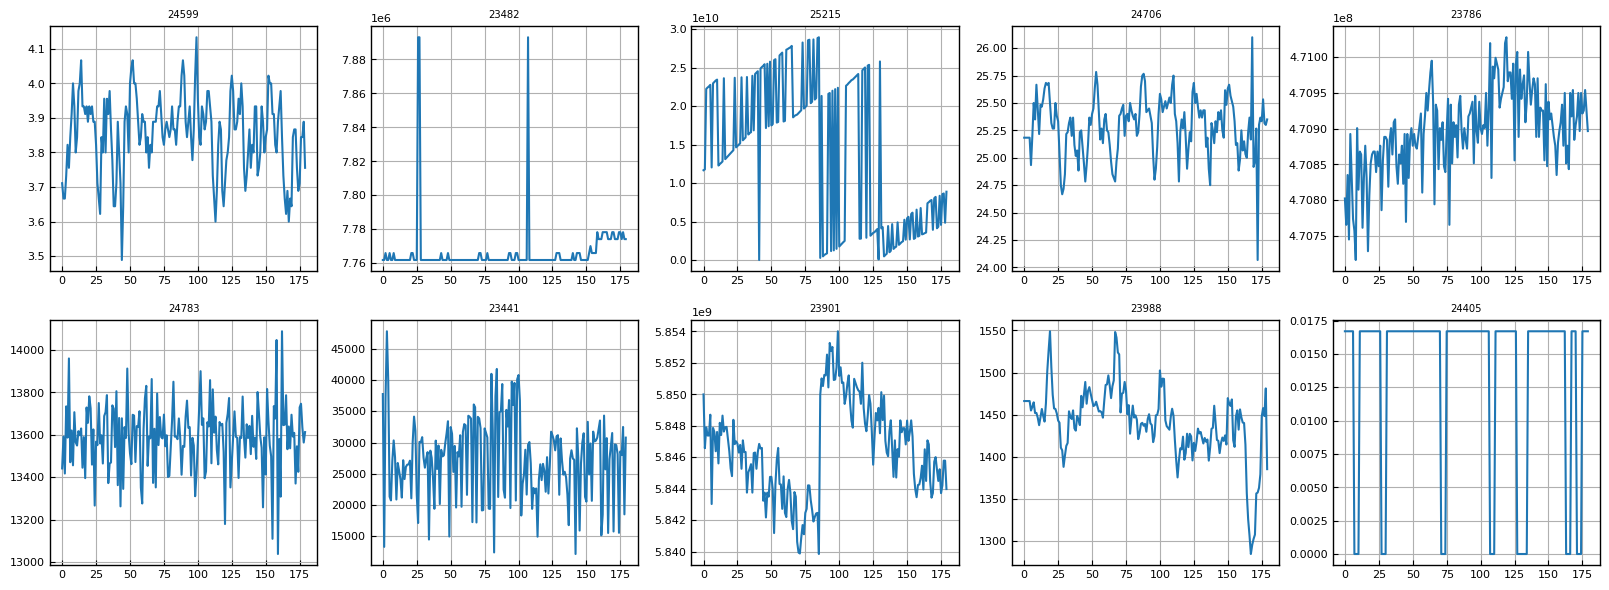

In [18]:
## plot the time series
fig, axs = plt.subplots(figsize=(20, 7), nrows=2, ncols=5)
for ax, (idx, ts) in zip(axs.flatten(), tmp_testset_df.loc[:, "time_series"].items()):
    ax.set_title(idx)
    ax.plot(ts)

In [19]:
tmp_testset_np = tmp_testset_df.loc[:, "time_series"].apply(scipy.stats.zscore, axis=0).to_numpy()
tmp_testset_np

array([array([-1.2896448 , -1.69188498, -1.69188498, -1.08852472, -0.28313843,
              -0.88649869, -0.08201834,  0.52224786,  1.32763415,  0.72336795,
              -0.48425851, -0.08201834,  1.12651407,  1.32763415,  1.93190036,
               0.72336795,  0.72336795,  0.52224786,  0.72336795,  0.32112778,
               0.72336795,  0.52224786,  0.72336795,  0.32112778,  0.32112778,
              -0.28313843, -1.2896448 , -1.69188498, -2.0950311 , -0.08201834,
              -0.48425851,  0.92539398, -0.48425851,  0.92358209,  0.52224786,
               1.12651407,  0.12091364, -0.6853786 , -1.89391101, -1.89391101,
              -1.2896448 ,  0.32112778, -0.48425851, -1.2896448 , -3.30265756,
              -1.89391101,  0.32112778,  0.72336795,  0.52224786, -0.48425851,
               1.32763415,  1.72987433,  1.93190036,  1.32763415,  1.32763415,
               0.92539398,  0.32112778, -0.28313843, -0.08201834,  0.52224786,
               0.32112778,  0.32112778, -0.48425851,

In [20]:
labels = knn_model.predict(tmp_testset_np)
labels

array(['Single dip/anomaly_outside_fault',
       'Multiple spikes/anomaly_during_fault', 'Other normal/no_anomaly',
       'White noise/no_anomaly', 'White noise/no_anomaly',
       'Single dip/anomaly_outside_fault',
       'Single dip/anomaly_during_fault', 'Other normal/no_anomaly',
       'Transient level shift down/anomaly_during_fault',
       'White noise/no_anomaly'], dtype=object)

In [22]:
tmp_testset_df.loc[:, ["anomaly_category"]] = labels
tmp_testset_df

,dataset_id,target_app,chaos_comp,chaos_type,metric,time_series,anomaly_pattern,anomaly_position,anomaly_category
24599,qknmc,sock-shop,orders-db,pod-cpu-hog,m-orders-db_mongodb_top_insert_count,"[3.7111, 3.6667, 3.6667, 3.7333, 3.8222, 3.755...",NaN,NaN,Single dip/anomaly_outside_fault
23482,qknmc,sock-shop,orders-db,pod-cpu-hog,c-payment_memory_working_set_bytes,"[7761920.0, 7761920.0, 7766016.0, 7761920.0, 7...",NaN,NaN,Multiple spikes/anomaly_during_fault
25215,qknmc,sock-shop,orders-db,pod-cpu-hog,m-shipping_java_lang_Threading_CurrentThreadUs...,"[11660000000.0, 11770000000.0, 22220000000.0, ...",NaN,NaN,Other normal/no_anomaly
24706,qknmc,sock-shop,orders-db,pod-cpu-hog,m-orders-db_mongodb_sys_netstat_IpExt_InNoECTPkts,"[25.1833, 25.1833, 25.1833, 25.1833, 25.1833, ...",NaN,NaN,White noise/no_anomaly
23786,qknmc,sock-shop,orders-db,pod-cpu-hog,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,"[470802432.0, 470765568.0, 470835200.0, 470745...",NaN,NaN,White noise/no_anomaly
24783,qknmc,sock-shop,orders-db,pod-cpu-hog,m-user-db_go_memstats_frees_total,"[13441.8667, 13591.2667, 13417.7778, 13734.0, ...",NaN,NaN,Single dip/anomaly_outside_fault
23441,qknmc,sock-shop,orders-db,pod-cpu-hog,c-orders-db_fs_writes_bytes_total,"[37759.0216, 13293.122, 37150.4364, 47809.282,...",NaN,NaN,Single dip/anomaly_during_fault
23901,qknmc,sock-shop,orders-db,pod-cpu-hog,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,"[5849993216.0, 5846573056.0, 5847896064.0, 584...",NaN,NaN,Other normal/no_anomaly
23988,qknmc,sock-shop,orders-db,pod-cpu-hog,m-carts-db_mongodb_top_insert_time,"[1466.15, 1466.15, 1466.15, 1466.15, 1466.15, ...",NaN,NaN,Transient level shift down/anomaly_during_fault
24405,qknmc,sock-shop,orders-db,pod-cpu-hog,m-orders-db_mongodb_ss_wt_reconciliation_pages...,"[0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.016...",NaN,NaN,White noise/no_anomaly


In [25]:
from tslearn.utils import to_time_series_dataset
distances, ind = knn_model.kneighbors(to_time_series_dataset(tmp_testset_np), n_neighbors=1)
distances

array([[[[[[-3.30265756]],

          [[-0.2657001 ]],

          [[ 1.18738229]],

          ...,

          [[-1.09727934]],

          [[ 0.80752249]],

          [[ 0.46499055]]],


         [[[-1.2896448 ]],

          [[-0.2657001 ]],

          [[-0.24612401]],

          ...,

          [[ 1.17447303]],

          [[ 0.6178462 ]],

          [[ 0.46499055]]],


         [[[ 0.32112778]],

          [[-0.2657001 ]],

          [[-1.47877029]],

          ...,

          [[ 0.11707556]],

          [[-0.06803045]],

          [[ 0.46499055]]],


         ...,


         [[[ 0.32112778]],

          [[-0.2657001 ]],

          [[ 1.57958793]],

          ...,

          [[-2.23590917]],

          [[-0.30172364]],

          [[ 0.46499055]]],


         [[[-2.29615118]],

          [[ 0.45169016]],

          [[-0.66581575]],

          ...,

          [[-0.68561028]],

          [[-3.74630984]],

          [[ 0.46499055]]],


         [[[ 0.52224786]],

          [[-0.2657001 ]],

## Active Learning for entire datasets

In [26]:
from dataclasses import dataclass

from IPython.display import HTML


NUM_ITEMS_BY_PAGE: int = 20
NUM_FAULT_DATAPOINTS: int = (60 // 15) * 5  # 15 sec sampling to 5min

@dataclass(frozen=True)
class TSWindowForAL:
    num_total_categories: int
    num_current_categories: int
    anomaly_pattern_name: str
    anomaly_position_name: str
    num_total_metrics_in_current_category: int
    num_current_metrics_in_current_category: int
    metrics_df_in_current_page: pd.DataFrame
    anomaly_min_distance: pd.Series
    
    def title_as_html(self) -> HTML:
        return HTML(f"<h3>Category: {self.anomaly_pattern_name}/{self.anomaly_position_name} - {self.num_current_categories}/{self.num_total_categories}</h3>")

    def msg_for_current_page(self) -> str:
        return f"Showing {self.num_current_metrics_in_current_category} of {self.num_total_metrics_in_current_category} metrics in the current pattern"
    
    def plots(self, axs) -> None:
        for ax in axs.flatten():
            ax.clear()
        for i, (ax, item) in enumerate(zip(axs.flatten(), self.metrics_df_in_current_page.itertuples())):
            ax.plot(item.time_series)
            ax.set_title(
                f"{item.Index}:\n {item.chaos_type}/{item.chaos_comp}/{item.metric}",
                wrap=True,
            )
            ax.axvspan(
                item.time_series.size - NUM_FAULT_DATAPOINTS,
                item.time_series.size, 
                color='red', alpha=0.5,
            )

In [27]:
import math

def create_widget_for_active_learning(yield_on_click, num_items_by_page: int = NUM_ITEMS_BY_PAGE) -> widgets.Box:
    all_correct_button = widgets.Button(description='All correct')
    skip_category_button = widgets.Button(description='Skip Category')
    mislabeled_items_selector = widgets.SelectMultiple(
        options=[],
        rows=num_items_by_page+2,
        disabled=False,
        layout=widgets.Layout(width='40%'),
        description='Selected mislabeled items',
    )
    title_output = widgets.Output(layout={'border': '1px solid black'})
    msg_output = widgets.Output(layout={'border': '1px solid black'})
    fig_output = widgets.Output(layout={'border': '1px solid black'})
    log_output = widgets.Output(layout={'border': '1px solid black'})

    plt.rcParams["font.size"] = 11
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    fig, axs = plt.subplots(
        nrows=num_items_by_page//5,
        ncols=5,
        figsize=(35, 3.5 * math.ceil(num_items_by_page / 5)),
        clear=True,
    )

    def show(tsw: TSWindowForAL) -> None:
        with title_output:
            title_output.clear_output(wait=True)
            display(tsw.title_as_html())
        with msg_output:
            msg_output.clear_output(wait=True)
            display(tsw.msg_for_current_page())

        tsw.plots(axs)
        with fig_output:
            fig_output.clear_output(wait=True)
            display(fig)
        
        with log_output:
            log_output.clear_output(wait=True)
            display(tsw.anomaly_min_distance)
        
        mislabeled_items_selector.options = tsw.metrics_df_in_current_page.index.tolist()

    def on_all_correct_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindowForAL = yield_on_click.send((mislabeled_items_selector.value))
        show(tsw)

    all_correct_button.on_click(on_all_correct_click_callback)
    plt.close(fig=fig)
    show(next(yield_on_click))

    def on_skip_category_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindowForAL = yield_on_click.send(("skip_category"))
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Category skipped")
        show(tsw)
    
    skip_category_button.on_click(on_skip_category_click_callback)

    return widgets.VBox([
        title_output,
        msg_output,
        fig_output,
        widgets.HBox([all_correct_button, skip_category_button]),
        widgets.HBox([mislabeled_items_selector, log_output]),
    ])

In [62]:
import datetime
from collections import defaultdict
import pathlib

import jsonlines

SAVE_DIR = pathlib.Path("../samples/tsdr_anomaly_patterns")

def generator_for_manual_batch_confirmation(
    predicted_df: pd.DataFrame,
    time: str = datetime.datetime.today().strftime('%Y%m%d-%H%M%S'),
):
    save_file_path: pathlib.Path = SAVE_DIR / f"mislabeled_tsdr_anomaly_patterns_{time}.jsonl"

    grped_predicted_df = predicted_df.sort_values("anomaly_min_distance", ascending=False).groupby("anomaly_category")
    for i, (acategory, grped_df) in enumerate(grped_predicted_df):
        for j in range(0, grped_df.shape[0], NUM_ITEMS_BY_PAGE):
            # make pager
            predicted_df_by_page: pd.DataFrame = grped_df.iloc[j:j+NUM_ITEMS_BY_PAGE]
            apattern, aposition = str(acategory).split("/")
            tsw = TSWindowForAL(
                num_total_categories=len(grped_predicted_df),
                num_current_categories=i+1,
                num_total_metrics_in_current_category=grped_df.shape[0],
                num_current_metrics_in_current_category=j+1,
                anomaly_pattern_name=apattern,
                anomaly_position_name=aposition,
                metrics_df_in_current_page=predicted_df_by_page,
                anomaly_min_distance=predicted_df_by_page["anomaly_min_distance"],
            )

            # Sent tsw to the UI widget's callback
            (v) = (yield tsw)
            if v == "skip_category":  # if skip_category button is clicked
                break
            mislabeled_df_index = v

            with jsonlines.open(str(save_file_path), mode='a', flush=True) as writer:
                for mislabeled_idx in mislabeled_df_index:
                    mislabeled_df = predicted_df_by_page.loc[mislabeled_idx, :]
                    writer.write({
                        "dataset_id": DATASET_ID, 
                        "target_app": mislabeled_df["target_app"], 
                        "chaos_type": mislabeled_df["chaos_type"],
                        "chaos_comp": mislabeled_df["chaos_comp"],
                        "metric": mislabeled_df["metric"],
                        "time_series": mislabeled_df["time_series"].tolist(),
                        "mislabeled_anomaly_pattern": apattern,
                        "mislabeled_anomaly_position": aposition,
                    })

In [29]:
knn_model = learn_anomaly_patterns_with_knn(train_X_df, k=1)

In [30]:
predicted_df: pd.DataFrame = predict_anomaly_patterns(
    [well_injected_fault_datasets[0]], knn_model,
)

In [32]:
_knn_model = learn_anomaly_patterns_with_knn(train_X_df, k=5)
_test_X_df = transform_to_testset([well_injected_fault_datasets[0]]).head(30)
# standarize time series for DTW
_test_X = _test_X_df.loc[:, "time_series"].apply(scipy.stats.zscore).to_numpy()
_test_X_df.loc[:, ["anomaly_category"]] = knn_model.predict(_test_X)
_proba_X = knn_model.predict_proba(to_time_series_dataset(_test_X))
# _test_X_df["proba"] = np.max(_proba_X)
# _test_X_df
display(_proba_X, np.max(_proba_X[0]), np.max(_proba_X[1]))

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

1.0

1.0

In [33]:
box = create_widget_for_active_learning(
    generator_for_manual_batch_confirmation(predicted_df)
)
display(box)

## Relabel mislabled samples

In [34]:
def load_mislabeled_samples(fpath: pathlib.Path) -> pd.DataFrame:
    with jsonlines.open(str(fpath), mode='r') as reader:
        mislabeled_samples = [sample for sample in reader]
    return pd.DataFrame(mislabeled_samples)

In [35]:
mislabeled_samples_df_01 = load_mislabeled_samples(SAVE_DIR / "mislabeled_tsdr_anomaly_patterns_20221122-111410.jsonl")
mislabeled_samples_df_01

,dataset_id,target_app,chaos_type,chaos_comp,metric,time_series,mislabeled_anomaly_pattern,mislabeled_anomaly_position
0,qknmc,sock-shop,pod-cpu-hog,carts,c-carts-db_fs_writes_bytes_total,"[35309.5562, 33667.2292, 28668.9501, 33370.014...",Level shift down,anomaly_during_fault
1,qknmc,sock-shop,pod-cpu-hog,carts,c-catalogue_memory_usage_bytes,"[9248768.0, 9248768.0, 9248768.0, 9248768.0, 9...",Level shift down,anomaly_during_fault
2,qknmc,sock-shop,pod-cpu-hog,carts,c-payment_memory_rss,"[7299072.0, 7299072.0, 7299072.0, 7299072.0, 7...",Level shift down,anomaly_during_fault
3,qknmc,sock-shop,pod-cpu-hog,carts,c-carts-db_fs_writes_bytes_total,"[35309.5562, 33667.2292, 28668.9501, 33370.014...",Level shift down,anomaly_during_fault
4,qknmc,sock-shop,pod-cpu-hog,carts,c-catalogue_memory_usage_bytes,"[9248768.0, 9248768.0, 9248768.0, 9248768.0, 9...",Level shift down,anomaly_during_fault
...,...,...,...,...,...,...,...,...
93,qknmc,sock-shop,pod-cpu-hog,carts,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,"[8118272.0, 8134656.0, 8138752.0, 8085504.0, 8...",White noise,no_anomaly
94,qknmc,sock-shop,pod-cpu-hog,carts,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,"[143847424.0, 143847424.0, 143847424.0, 143847...",White noise,no_anomaly
95,qknmc,sock-shop,pod-cpu-hog,carts,m-carts-db_mongodb_ss_wt_reconciliation_pages_...,"[0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.016...",White noise,no_anomaly
96,qknmc,sock-shop,pod-cpu-hog,carts,m-carts-db_mongodb_ss_wt_reconciliation_approx...,"[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.0667, 1....",White noise,no_anomaly


In [36]:
pd.DataFrame(
    {
        f"{row.Index}:{row.chaos_type}/{row.chaos_comp}/{row.metric}": row.time_series
        for row in mislabeled_samples_df_01.itertuples()
    },
)

,0:pod-cpu-hog/carts/c-carts-db_fs_writes_bytes_total,1:pod-cpu-hog/carts/c-catalogue_memory_usage_bytes,2:pod-cpu-hog/carts/c-payment_memory_rss,3:pod-cpu-hog/carts/c-carts-db_fs_writes_bytes_total,4:pod-cpu-hog/carts/c-catalogue_memory_usage_bytes,5:pod-cpu-hog/carts/c-payment_memory_rss,6:pod-cpu-hog/carts/c-carts-db_fs_writes_bytes_total,7:pod-cpu-hog/carts/c-catalogue_memory_usage_bytes,8:pod-cpu-hog/carts/c-payment_memory_rss,9:pod-cpu-hog/carts/n-gke-meltria-sockshop-01-default-pool-cf9d09ec-87sx_go_memstats_other_sys_bytes,...,88:pod-cpu-hog/carts/c-carts-db_cpu_usage_seconds_total,89:pod-cpu-hog/carts/c-catalogue_cpu_cfs_periods_total,90:pod-cpu-hog/carts/c-front-end_cpu_cfs_periods_total,91:pod-cpu-hog/carts/c-payment_cpu_usage_seconds_total,92:pod-cpu-hog/carts/c-user-db_cpu_cfs_periods_total,93:pod-cpu-hog/carts/n-gke-meltria-sockshop-01-default-pool-cf9d09ec-cvtz_memory_PageTables_bytes,94:pod-cpu-hog/carts/n-gke-meltria-sockshop-01-default-pool-cf9d09ec-0vtp_memory_SReclaimable_bytes,95:pod-cpu-hog/carts/m-carts-db_mongodb_ss_wt_reconciliation_pages_written_including_at_least_one_start_transaction_ID,96:pod-cpu-hog/carts/m-carts-db_mongodb_ss_wt_reconciliation_approximate_byte_size_of_transaction_IDs_in_pages_written,97:pod-cpu-hog/carts/m-carts-db_mongodb_ss_logicalSessionRecordCache_activeSessionsCount
0,35309.5562,9248768.0,7299072.0,35309.5562,9248768.0,7299072.0,35309.5562,9248768.0,7299072.0,618163.0,...,0.0362,7.1588,8.3678,0.0019,8.3068,8118272.0,143847424.0,0.0167,1.2,0.1333
1,33667.2292,9248768.0,7299072.0,33667.2292,9248768.0,7299072.0,33667.2292,9248768.0,7299072.0,618163.0,...,0.0358,6.6639,7.5201,0.0026,8.0381,8134656.0,143847424.0,0.0167,1.2,0.1333
2,28668.9501,9248768.0,7299072.0,28668.9501,9248768.0,7299072.0,28668.9501,9248768.0,7299072.0,617939.0,...,0.0357,6.4092,6.9674,0.0026,6.6070,8138752.0,143847424.0,0.0167,1.2,0.1333
3,33370.0144,9248768.0,7299072.0,33370.0144,9248768.0,7299072.0,33370.0144,9248768.0,7299072.0,617939.0,...,0.0367,6.1304,6.6458,0.0022,7.7619,8085504.0,143847424.0,0.0167,1.2,0.1333
4,35247.3108,9248768.0,7299072.0,35247.3108,9248768.0,7299072.0,35247.3108,9248768.0,7299072.0,617939.0,...,0.0378,5.1994,7.5168,0.0026,8.1935,8134656.0,143847424.0,0.0167,1.2,0.1333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,29632.9988,8470528.0,7434240.0,29632.9988,8470528.0,7434240.0,29632.9988,8470528.0,7434240.0,601851.0,...,0.0235,3.8763,5.7400,0.0019,6.6552,8167424.0,143876096.0,0.0167,1.2,0.1111
176,33062.8428,8470528.0,7434240.0,33062.8428,8470528.0,7434240.0,33062.8428,8470528.0,7434240.0,601851.0,...,0.0316,3.5286,5.6440,0.0019,6.5047,8155136.0,143876096.0,0.0167,1.2,0.1111
177,29534.3339,8470528.0,7434240.0,29534.3339,8470528.0,7434240.0,29534.3339,8470528.0,7434240.0,601851.0,...,0.0318,3.8848,5.3134,0.0019,6.8824,8142848.0,143876096.0,0.0167,1.2,0.1333
178,22588.5547,8470528.0,7434240.0,22588.5547,8470528.0,7434240.0,22588.5547,8470528.0,7434240.0,601851.0,...,0.0317,4.1748,6.2506,0.0021,7.1068,8155136.0,143876096.0,0.0167,1.2,0.1333


In [37]:
import re

unique_column_pattern: re.Pattern = re.compile(r"(\d+):([\w-]+)/([\w-]+)/([\w-]+)")

def convert_to_df_as_time_index(samples_df: pd.DataFrame):
    return pd.DataFrame({
        f"{row.Index}:{row.chaos_type}/{row.chaos_comp}/{row.metric}": np.array(row.time_series)
        for row in samples_df.itertuples()
    })


In [38]:
from typing import Generator


def generator_for_relabeling(
    samples_df: pd.DataFrame,
    time: str = datetime.datetime.today().strftime('%Y%m%d-%H%M%S'),
) -> Generator:
    save_file_path: pathlib.Path = SAVE_DIR / f"relabeled_tsdr_anomaly_patterns_{time}.jsonl"

    metrics_df: pd.DataFrame = convert_to_df_as_time_index(samples_df)
    nz_metrics_df = metrics_df.apply(scipy.stats.zscore)
    labeled_sample_ids: set[int] = set()
    total_num_metrics = nz_metrics_df.shape[1]
    for sample in samples_df.itertuples():
        if sample.Index in labeled_sample_ids:
            continue

        current_metric_name: str = f"{sample.Index}:{sample.chaos_type}/{sample.chaos_comp}/{sample.metric}"

        nz_similar_metrics_df, top_score = find_similar_metrics(
            nz_metrics_df, current_metric_name, k=10, method="dtw"
        )

        tsw = TSWindow(
            total_records=1,
            current_record_no=1,
            record=record,
            total_metrics_in_current_record=total_num_metrics,
            current_metric=current_metric_name,
            current_metric_ts=np.array(sample.time_series),
            current_metrics_no_in_current_record=len(labeled_sample_ids),
            sli_metric_ts=np.array([0.0] * len(sample.time_series)),
            sli_metric="no sli",
            similar_metrics_df=metrics_df.loc[:, nz_similar_metrics_df.columns],
            similar_metrics_top_score=top_score,
            progress_stats=progress_stats(save_file_path),
        )

        # Sent tsw to the UI widget's callback
        (v) = (yield tsw)
        if v == "skip":  # skip button is clicked
            continue
        elif v == "skip_record":  # if skip_record button is clicked
            break
        ((position, pattern_name), similar_metrics) = v  # if save button is clicked

        with jsonlines.open(str(save_file_path), mode='a', flush=True) as writer:
            _metrics: list[str] = [current_metric_name] + list(similar_metrics)
            for _metric in _metrics:
                _idx, chaos_type, chaos_comp, base_metric_name = unique_column_pattern.match(_metric).groups()
                idx = int(_idx)
                sample_df = samples_df.loc[idx, :]
                writer.write({
                    'dataset_id': sample_df["dataset_id"], 
                    'target_app': sample_df["target_app"], 
                    'chaos_type': sample_df["chaos_type"],
                    'chaos_comp': sample_df["chaos_comp"],
                    'metric': base_metric_name,
                    'anomaly_position': position,
                    'anomaly_pattern': pattern_name,
                    'time_series': sample_df["time_series"],
                })
                labeled_sample_ids.add(idx)
            nz_metrics_df.drop(columns=_metrics, inplace=True)

In [39]:
create_widget_for_labeling(
    generator_for_relabeling(mislabeled_samples_df_01.drop_duplicates(subset=["chaos_type", "chaos_comp", "metric"]))
)

## Apply corrected labels

In [40]:
relabeled_samples_df_01 = load_mislabeled_samples(SAVE_DIR / "relabeled_tsdr_anomaly_patterns_20221123-101157.jsonl")
relabeled_samples_df_01

,dataset_id,target_app,chaos_type,chaos_comp,metric,anomaly_position,anomaly_pattern,time_series
0,qknmc,sock-shop,pod-cpu-hog,carts,c-carts-db_fs_writes_bytes_total,no_anomaly,White noise,"[35309.5562, 33667.2292, 28668.9501, 33370.014..."
1,qknmc,sock-shop,pod-cpu-hog,carts,m-carts-db_go_gc_cycles_total_gc_cycles_total,no_anomaly,White noise,"[0.6444, 0.6444, 0.6444, 0.6667, 0.6667, 0.666..."
2,qknmc,sock-shop,pod-cpu-hog,carts,m-carts-db_go_gc_cycles_automatic_gc_cycles_total,no_anomaly,White noise,"[0.6444, 0.6444, 0.6444, 0.6667, 0.6667, 0.666..."
3,qknmc,sock-shop,pod-cpu-hog,carts,c-catalogue_memory_usage_bytes,anomaly_outside_fault,Level shift down,"[9248768.0, 9248768.0, 9248768.0, 9248768.0, 9..."
4,qknmc,sock-shop,pod-cpu-hog,carts,c-payment_memory_rss,anomaly_outside_fault,Level shift up,"[7299072.0, 7299072.0, 7299072.0, 7299072.0, 7..."
...,...,...,...,...,...,...,...,...
87,qknmc,sock-shop,pod-cpu-hog,carts,c-payment_cpu_usage_seconds_total,anomaly_during_fault,Level shift down,"[0.0019, 0.0026, 0.0026, 0.0022, 0.0026, 0.002..."
88,qknmc,sock-shop,pod-cpu-hog,carts,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,anomaly_outside_fault,Single dip,"[8118272.0, 8134656.0, 8138752.0, 8085504.0, 8..."
89,qknmc,sock-shop,pod-cpu-hog,carts,m-carts-db_mongodb_ss_wt_reconciliation_pages_...,anomaly_outside_fault,Multiple dips,"[0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.016..."
90,qknmc,sock-shop,pod-cpu-hog,carts,m-carts-db_mongodb_ss_wt_reconciliation_approx...,anomaly_outside_fault,Multiple dips,"[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.0667, 1...."


In [41]:
all_train_X_df = pd.read_json(str(samples_file), orient='records', lines=True)

# convert_to_df_as_time_index(all_train_X_df).plot(layout=(math.ceil(all_train_X_df.size / 5), 5), subplots=True, figsize=(25, 500))
# for group in  all_train_X_df.groupby(["anomaly_pattern", "anomaly_position"]):
#     nrows = math.ceil(group[1].size / 4)
#     axs = convert_to_df_as_time_index(group[1]).plot(layout=(nrows, 4), subplots=True, figsize=(25, 2.5*nrows))
#     axs[0][0].get_figure().suptitle(f"{group[0][0]}:{group[0][1]}")

In [42]:
# for group in all_train_X_df.groupby(["anomaly_pattern", "anomaly_position"]):
#   display(group[0], convert_to_df_as_time_index(group[1]).columns)

In [43]:
delete_columns_samples_01 = [
    '108:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_CollectionCount',
    '109:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_LastGcInfo_endTime',
    '110:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_LastGcInfo_startTime',
    '111:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_CollectionTime',
    '113:pod-memory-hog/orders/m-orders_java_nio_BufferPool_MemoryUsed',
    '114:pod-memory-hog/orders/m-orders_java_nio_BufferPool_TotalCapacity',
    '184:pod-memory-hog/user-db/m-user-db_mongodb_ss_opLatencies_latency',
    '209:pod-memory-hog/orders-db/m-orders-db_mongodb_ss_opLatencies_latency',
    '215:pod-memory-hog/orders-db/s-front-end_throughput',
    '260:pod-network-loss/orders-db/s-orders_throughput',
    '278:pod-network-loss/orders/m-orders_Tomcat_Servlet_processingTime',
    '279:pod-network-loss/orders/m-orders_Tomcat_RequestProcessor_processingTime', 
    '280:pod-network-loss/orders/m-orders_Tomcat_WebModule_processingTime',
    '281:pod-network-loss/orders/m-orders_Tomcat_GlobalRequestProcessor_processingTime', 
    '282:pod-network-loss/orders/s-orders_throughput',
    '284:pod-network-loss/orders/m-orders-db_mongodb_ss_network_bytesIn',
    '285:pod-network-loss/orders/m-orders-db_mongodb_ss_network_physicalBytesIn',
    '286:pod-network-loss/orders/m-orders-db_mongodb_ss_opLatencies_ops',
    '309:pod-network-loss/carts-db/m-carts_Tomcat_Manager_processingTime',
    '7:pod-memory-hog/catalogue/c-catalogue_memory_usage_bytes',
    '11:pod-memory-hog/front-end/c-front-end_memory_working_set_bytes',
    '12:pod-memory-hog/front-end/c-front-end_memory_rss',
    '59:pod-memory-hog/carts-db/m-carts-db_mongodb_sys_memory_Active_kb',
    '69:pod-memory-hog/catalogue-db/c-catalogue-db_memory_working_set_bytes',
    '70:pod-memory-hog/catalogue-db/c-catalogue-db_memory_rss',
    '71:pod-memory-hog/catalogue-db/c-catalogue-db_memory_usage_bytes',
    '73:pod-memory-hog/catalogue-db/c-catalogue-db_threads',
    '78:pod-memory-hog/orders/m-orders_java_lang_OperatingSystem_SystemCpuLoad',
    '143:pod-memory-hog/payment/c-payment_memory_usage_bytes',
    '144:pod-memory-hog/payment/c-payment_memory_working_set_bytes',
    '159:pod-memory-hog/user-db/m-user-db_mongodb_sys_memory_Active_file_kb',
    '160:pod-memory-hog/user-db/m-user-db_mongodb_sys_memory_Active_kb',
    '185:pod-memory-hog/orders-db/c-orders-db_memory_rss',
    '186:pod-memory-hog/orders-db/c-orders-db_memory_working_set_bytes',
    '187:pod-memory-hog/orders-db/m-orders-db_mongodb_sys_memory_Active_kb',
    '188:pod-memory-hog/orders-db/m-orders-db_mongodb_sys_memory_Active_file_kb',
    '189:pod-memory-hog/orders-db/c-orders-db_threads',
    '199:pod-memory-hog/orders-db/s-orders_latency',
    '270:pod-network-loss/orders-db/m-orders_Tomcat_RequestProcessor_requestBytesReceived',
    '224:pod-memory-hog/user/c-user_memory_working_set_bytes',
    '223:pod-memory-hog/user/c-user_memory_usage_bytes',
    '201:pod-memory-hog/orders-db/m-orders_Tomcat_GlobalRequestProcessor_processingTime',
    '52:pod-memory-hog/carts-db/m-carts_Tomcat_GlobalRequestProcessor_requestCount',
    '53:pod-memory-hog/carts-db/m-carts_Tomcat_RequestProcessor_bytesReceived',
    '54:pod-memory-hog/carts-db/m-carts_Tomcat_RequestProcessor_requestCount',
    '55:pod-memory-hog/carts-db/m-carts_Tomcat_RequestProcessor_bytesSent',
    '56:pod-memory-hog/carts-db/m-carts_Tomcat_GlobalRequestProcessor_bytesSent',
    '76:pod-memory-hog/catalogue-db/s-front-end_throughput',
    '82:pod-memory-hog/orders/m-orders_java_lang_MemoryPool_PeakUsage_committed',
    '83:pod-memory-hog/orders/m-orders_java_lang_MemoryPool_Usage_committed',
    '84:pod-memory-hog/orders/m-orders_java_lang_MemoryPool_PeakUsage_used',
    '85:pod-memory-hog/orders/m-orders_java_lang_Memory_NonHeapMemoryUsage_used',
    '86:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_LastGcInfo_memoryUsageAfterGc_used',
    '87:pod-memory-hog/orders/m-orders_java_lang_Memory_NonHeapMemoryUsage_committed',
    '88:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_LastGcInfo_memoryUsageBeforeGc_used',
    '89:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_LastGcInfo_memoryUsageAfterGc_committed',
    '90:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_LastGcInfo_memoryUsageBeforeGc_committed',
    '91:pod-memory-hog/orders/m-orders_java_lang_MemoryPool_CollectionUsage_committed',
    '101:pod-memory-hog/orders/m-orders_java_lang_MemoryPool_CollectionUsage_used',
    '103:pod-memory-hog/orders/m-orders_Tomcat_WebModule_requestCount',
    '104:pod-memory-hog/orders/m-orders_Tomcat_Servlet_requestCount',
    '105:pod-memory-hog/orders/m-orders_Tomcat_RequestProcessor_requestCount',
    '106:pod-memory-hog/orders/m-orders_Tomcat_GlobalRequestProcessor_requestCount',
    '107:pod-memory-hog/orders/s-orders_throughput',
    '124:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_LastGcInfo_memoryUsageAfterGc_init',
    '125:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_LastGcInfo_memoryUsageAfterGc_max',
    '126:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_LastGcInfo_memoryUsageBeforeGc_max',
    '127:pod-memory-hog/orders/m-orders_java_lang_GarbageCollector_LastGcInfo_GcThreadCount',
    '191:pod-memory-hog/orders-db/m-orders_Tomcat_GlobalRequestProcessor_requestCount',
    '192:pod-memory-hog/orders-db/m-orders_Tomcat_RequestProcessor_bytesSent',
    '193:pod-memory-hog/orders-db/m-orders_Tomcat_WebModule_requestCount',
    '194:pod-memory-hog/orders-db/m-orders_Tomcat_RequestProcessor_bytesReceived',
    '195:pod-memory-hog/orders-db/m-orders_Tomcat_GlobalRequestProcessor_bytesSent',
    '196:pod-memory-hog/orders-db/m-orders_Tomcat_Servlet_requestCount',
    '197:pod-memory-hog/orders-db/m-orders_Tomcat_RequestProcessor_requestCount',
    '198:pod-memory-hog/orders-db/s-orders_throughput',   
    '205:pod-memory-hog/orders-db/m-orders-db_mongodb_sys_memory_MemAvailable_kb',
    '321:pod-cpu-hog/orders/s-front-end_errors',
    '272:pod-network-loss/orders/m-orders_Tomcat_GlobalRequestProcessor_requestCount',
    '273:pod-network-loss/orders/m-orders_Tomcat_Servlet_requestCount',
    '275:pod-network-loss/orders/m-orders_Tomcat_RequestProcessor_requestCount',
    '276:pod-network-loss/orders/m-orders_Tomcat_RequestProcessor_bytesReceived',
    '1:pod-memory-hog/catalogue/c-catalogue_memory_rss',
    '2:pod-memory-hog/catalogue/c-catalogue_threads',
    '16:pod-memory-hog/front-end/c-front-end_processes',
    '17:pod-memory-hog/front-end/c-front-end_threads',
    '31:pod-memory-hog/carts-db/m-carts_Tomcat_GlobalRequestProcessor_processingTime',
    '32:pod-memory-hog/carts-db/m-carts_Tomcat_WebModule_processingTime',
    '33:pod-memory-hog/carts-db/m-carts_Tomcat_RequestProcessor_processingTime',
    '34:pod-memory-hog/carts-db/m-carts_Tomcat_Servlet_processingTime',
    '36:pod-memory-hog/carts-db/m-carts-db_mongodb_sys_memory_Buffers_kb',
    '68:pod-memory-hog/catalogue-db/s-front-end_latency',
    '94:pod-memory-hog/orders/m-orders_Tomcat_Servlet_processingTime',
    '95:pod-memory-hog/orders/m-orders_Tomcat_WebModule_processingTime',
    '96:pod-memory-hog/orders/m-orders_Tomcat_GlobalRequestProcessor_processingTime',
    '97:pod-memory-hog/orders/m-orders_Tomcat_RequestProcessor_processingTime',
    '129:pod-memory-hog/payment/c-payment_threads',
    '130:pod-memory-hog/payment/c-payment_processes',
    '182:pod-memory-hog/user-db/m-user-db_mongodb_sys_memory_Buffers_kb',
    '204:pod-memory-hog/orders-db/c-orders-db_processes',
    '216:pod-memory-hog/user/c-user_threads',
    '217:pod-memory-hog/user/c-user_processes',
    '218:pod-memory-hog/user/c-user_memory_rss',
    '219:pod-memory-hog/user/m-orders_Tomcat_Manager_processingTime',
    '221:pod-memory-hog/user/s-user_latency',
    '262:pod-network-loss/orders-db/m-orders_Tomcat_RequestProcessor_requestBytesSent',
    '263:pod-network-loss/orders-db/m-orders_Tomcat_WebModule_requestCount'
    '203:pod-memory-hog/orders-db/m-orders_Tomcat_RequestProcessor_requestBytesSent',
    '265:pod-network-loss/orders-db/m-orders-db_mongodb_ss_network_physicalBytesOut',
    '247:pod-network-loss/orders-db/m-orders_Tomcat_GlobalRequestProcessor_requestCount',
    '248:pod-network-loss/orders-db/m-orders_Tomcat_RequestProcessor_requestCount',
    '249:pod-network-loss/orders-db/m-orders_Tomcat_RequestProcessor_bytesReceived',
    '250:pod-network-loss/orders-db/m-orders_Tomcat_RequestProcessor_bytesSent'
    '211:pod-memory-hog/orders-db/m-orders_Tomcat_WebModule_processingTime',
    '257:pod-network-loss/orders-db/m-orders_Tomcat_WebModule_processingTime',
    '303:pod-network-loss/carts-db/m-carts_Tomcat_RequestProcessor_processingTime',
    '304:pod-network-loss/carts-db/m-carts_Tomcat_GlobalRequestProcessor_processingTime',
    '305:pod-network-loss/carts-db/m-carts_Tomcat_Servlet_processingTime',
    '306:pod-network-loss/carts-db/m-carts_Tomcat_WebModule_processingTime',
    '307:pod-network-loss/carts-db/s-carts_latency',
    '308:pod-network-loss/carts-db/m-carts_Tomcat_RequestProcessor_requestProcessingTime',
	'9:pod-memory-hog/catalogue/s-front-end_throughput',
       '19:pod-memory-hog/carts-db/m-orders_Tomcat_GlobalRequestProcessor_bytesReceived',
       '20:pod-memory-hog/carts-db/m-orders_Tomcat_GlobalRequestProcessor_requestCount',
       '21:pod-memory-hog/carts-db/m-orders_Tomcat_WebModule_requestCount',
       '22:pod-memory-hog/carts-db/m-orders_Tomcat_RequestProcessor_bytesReceived',
       '23:pod-memory-hog/carts-db/m-orders_Tomcat_RequestProcessor_requestCount',
       '24:pod-memory-hog/carts-db/m-orders_Tomcat_Servlet_requestCount',
       '25:pod-memory-hog/carts-db/m-orders_Tomcat_GlobalRequestProcessor_bytesSent',
       '26:pod-memory-hog/carts-db/m-orders_Tomcat_RequestProcessor_bytesSent',
       '27:pod-memory-hog/carts-db/s-carts_throughput',
       '28:pod-memory-hog/carts-db/s-front-end_throughput',
	   '29:pod-memory-hog/carts-db/m-carts_Tomcat_Servlet_requestCount',
	   '47:pod-memory-hog/carts-db/m-carts-db_mongodb_ss_opLatencies_latency',
       '48:pod-memory-hog/carts-db/m-carts_Tomcat_WebModule_requestCount',
       '64:pod-memory-hog/carts-db/s-orders_throughput',
	   '79:pod-memory-hog/orders/m-orders-db_mongodb_ss_opLatencies_ops',
       '80:pod-memory-hog/orders/s-front-end_throughput',
       '81:pod-memory-hog/orders/m-orders-db_mongodb_ss_opLatencies_latency',
       '132:pod-memory-hog/payment/m-orders_Tomcat_GlobalRequestProcessor_bytesReceived',
       '133:pod-memory-hog/payment/m-orders_Tomcat_GlobalRequestProcessor_requestCount',
       '134:pod-memory-hog/payment/m-orders_Tomcat_RequestProcessor_bytesReceived',
       '135:pod-memory-hog/payment/m-orders_Tomcat_RequestProcessor_requestCount',
       '136:pod-memory-hog/payment/m-orders_Tomcat_WebModule_requestCount',
	   '137:pod-memory-hog/payment/m-orders_Tomcat_GlobalRequestProcessor_bytesSent',
       '138:pod-memory-hog/payment/m-orders_Tomcat_Servlet_requestCount',
       '139:pod-memory-hog/payment/m-orders_Tomcat_RequestProcessor_bytesSent',
       '140:pod-memory-hog/payment/s-front-end_throughput',
       '141:pod-memory-hog/payment/s-orders_throughput',
       '142:pod-memory-hog/payment/s-payment_throughput',
       '161:pod-memory-hog/user-db/m-orders_Tomcat_GlobalRequestProcessor_bytesReceived',
       '162:pod-memory-hog/user-db/m-orders_Tomcat_GlobalRequestProcessor_requestCount',
       '163:pod-memory-hog/user-db/m-orders_Tomcat_WebModule_requestCount',
       '164:pod-memory-hog/user-db/m-orders_Tomcat_RequestProcessor_bytesReceived',
       '165:pod-memory-hog/user-db/m-orders_Tomcat_RequestProcessor_requestCount',
       '166:pod-memory-hog/user-db/m-orders_Tomcat_Servlet_requestCount',
       '167:pod-memory-hog/user-db/m-orders_Tomcat_GlobalRequestProcessor_bytesSent',
       '168:pod-memory-hog/user-db/m-orders_Tomcat_RequestProcessor_bytesSent',
       '169:pod-memory-hog/user-db/s-user_throughput',
       '170:pod-memory-hog/user-db/s-front-end_throughput',
	          '171:pod-memory-hog/user-db/s-orders_throughput',
			   '176:pod-memory-hog/user-db/m-orders_Tomcat_WebModule_processingTime',
       '177:pod-memory-hog/user-db/m-orders_Tomcat_Servlet_processingTime',
       '178:pod-memory-hog/user-db/m-orders_Tomcat_GlobalRequestProcessor_processingTime',
       '179:pod-memory-hog/user-db/s-front-end_errors',
	    '225:pod-memory-hog/user/m-orders_Tomcat_GlobalRequestProcessor_bytesReceived',
       '226:pod-memory-hog/user/m-orders_Tomcat_GlobalRequestProcessor_requestCount',
       '227:pod-memory-hog/user/m-orders_Tomcat_WebModule_requestCount',
       '228:pod-memory-hog/user/m-orders_Tomcat_Servlet_requestCount',
       '229:pod-memory-hog/user/m-orders_Tomcat_RequestProcessor_bytesReceived',
       '230:pod-memory-hog/user/m-orders_Tomcat_RequestProcessor_requestCount',
	  '231:pod-memory-hog/user/m-orders_Tomcat_GlobalRequestProcessor_bytesSent',
       '232:pod-memory-hog/user/m-orders_Tomcat_RequestProcessor_bytesSent',
       '233:pod-memory-hog/user/m-user-db_mongodb_ss_opLatencies_ops',
       '234:pod-memory-hog/user/s-user_throughput', 
	   '235:pod-memory-hog/user/s-front-end_throughput',
	'239:pod-memory-hog/user/m-orders_Tomcat_GlobalRequestProcessor_processingTime',
       '240:pod-memory-hog/user/m-orders_Tomcat_WebModule_processingTime',
       '241:pod-memory-hog/user/m-orders_Tomcat_Servlet_processingTime',
       '242:pod-memory-hog/user/s-orders_throughput',
       '243:pod-memory-hog/user/m-user-db_mongodb_ss_opLatencies_latency'
	   '39:pod-memory-hog/carts-db/c-carts-db_memory_rss',
	          '41:pod-memory-hog/carts-db/c-carts-db_processes',
			   '43:pod-memory-hog/carts-db/m-orders_Tomcat_Servlet_processingTime',
       '44:pod-memory-hog/carts-db/m-orders_Tomcat_WebModule_processingTime',
       '45:pod-memory-hog/carts-db/m-orders_Tomcat_GlobalRequestProcessor_processingTime',
	          '118:pod-memory-hog/orders/c-orders_processes',
			  '120:pod-memory-hog/orders/c-orders_memory_working_set_bytes',
       '121:pod-memory-hog/orders/c-orders_memory_rss',
	    '145:pod-memory-hog/payment/m-orders_Tomcat_RequestProcessor_requestProcessingTime',
		 '149:pod-memory-hog/payment/m-orders_Tomcat_WebModule_processingTime',
       '150:pod-memory-hog/payment/m-orders_Tomcat_RequestProcessor_processingTime',
       '151:pod-memory-hog/payment/m-orders_Tomcat_Servlet_processingTime',
	    '155:pod-memory-hog/user-db/c-user-db_memory_working_set_bytes',
       '156:pod-memory-hog/user-db/c-user-db_processes',
       '157:pod-memory-hog/user-db/c-user-db_memory_rss',
	   '288:pod-network-loss/orders/m-orders_Tomcat_Servlet_errorCount',
       '289:pod-network-loss/orders/m-orders_Tomcat_RequestProcessor_errorCount',
	   '290:pod-network-loss/orders/m-orders_Tomcat_GlobalRequestProcessor_errorCount',
       '291:pod-network-loss/orders/m-orders_Tomcat_RequestProcessor_bytesSent',
       '292:pod-network-loss/orders/m-orders_Tomcat_GlobalRequestProcessor_bytesSent',
	   '295:pod-network-loss/user-db/m-user-db_mongodb_ss_network_physicalBytesIn',
       '296:pod-network-loss/user-db/m-user-db_mongodb_ss_network_bytesOut',
       '297:pod-network-loss/user-db/m-user-db_mongodb_ss_network_physicalBytesOut',
	   '328:pod-cpu-hog/payment/m-orders_Tomcat_GlobalRequestProcessor_bytesSent',
       '329:pod-cpu-hog/payment/s-orders_throughput',
]
cleaned_all_train_X_df = all_train_X_df.drop(index=[int(unique_column_pattern.match(col).groups()[0]) for col in delete_columns_samples_01])

In [44]:
relabeled_and_cleaned_train_x_df = pd.concat([cleaned_all_train_X_df, relabeled_samples_df_01])
relabeled_and_cleaned_train_x_df

,dataset_id,target_app,chaos_type,chaos_comp,metric,anomaly_position,anomaly_pattern,time_series
0,qknmc,sock-shop,pod-memory-hog,catalogue,c-catalogue_processes,anomaly_during_fault,Single spike,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,qknmc,sock-shop,pod-memory-hog,catalogue,s-catalogue_latency,anomaly_during_fault,Single spike,"[0.0017000000000000001, 0.0017000000000000001,..."
4,qknmc,sock-shop,pod-memory-hog,catalogue,s-front-end_errors,anomaly_during_fault,Single spike,"[0.4667, 0.6000000000000001, 0.5111, 0.4444, 0..."
5,qknmc,sock-shop,pod-memory-hog,catalogue,s-front-end_latency,anomaly_during_fault,Multiple spikes,"[0.0114, 0.0122, 0.0126, 0.0128, 0.0122, 0.011..."
6,qknmc,sock-shop,pod-memory-hog,catalogue,c-catalogue_memory_working_set_bytes,anomaly_during_fault,Level shift up,"[8060928.0, 8060928.0, 8060928.0, 8060928.0, 8..."
...,...,...,...,...,...,...,...,...
87,qknmc,sock-shop,pod-cpu-hog,carts,c-payment_cpu_usage_seconds_total,anomaly_during_fault,Level shift down,"[0.0019, 0.0026, 0.0026, 0.0022, 0.0026, 0.002..."
88,qknmc,sock-shop,pod-cpu-hog,carts,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,anomaly_outside_fault,Single dip,"[8118272.0, 8134656.0, 8138752.0, 8085504.0, 8..."
89,qknmc,sock-shop,pod-cpu-hog,carts,m-carts-db_mongodb_ss_wt_reconciliation_pages_...,anomaly_outside_fault,Multiple dips,"[0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.016..."
90,qknmc,sock-shop,pod-cpu-hog,carts,m-carts-db_mongodb_ss_wt_reconciliation_approx...,anomaly_outside_fault,Multiple dips,"[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.0667, 1...."


In [53]:
gs_clf = grid_search_anomaly_patterns(relabeled_and_cleaned_train_x_df)
gs_clf

GridSearchCV(cv=LeaveOneOut(), error_score='raise',
             estimator=KNeighborsTimeSeriesClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10)})

In [54]:
pd.DataFrame(gs_clf.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split212_test_score,split213_test_score,split214_test_score,split215_test_score,split216_test_score,split217_test_score,split218_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031857,0.035218,0.238676,0.261811,1,{'n_neighbors': 1},0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.602740,0.489331,1
3,0.027168,0.013036,0.185917,0.030067,4,{'n_neighbors': 4},0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.589041,0.492008,2
5,0.024286,0.010651,0.178996,0.025576,6,{'n_neighbors': 6},1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.589041,0.492008,2
6,0.026671,0.012588,0.174222,0.024383,7,{'n_neighbors': 7},0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.589041,0.492008,2
4,0.027568,0.013988,0.181443,0.030264,5,{'n_neighbors': 5},0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.575342,0.494291,5
2,0.027524,0.013882,0.177771,0.027137,3,{'n_neighbors': 3},0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.561644,0.496185,6
7,0.026247,0.011834,0.178555,0.026420,8,{'n_neighbors': 8},0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.552511,0.497235,7
1,0.024560,0.011331,0.179135,0.026532,2,{'n_neighbors': 2},0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.543379,0.498115,8
8,0.024906,0.010792,0.178219,0.027071,9,{'n_neighbors': 9},0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.538813,0.498491,9


In [71]:
## Soft-DTW
gs_clf = grid_search_anomaly_patterns(
    relabeled_and_cleaned_train_x_df,
    metric='softdtw',
    metric_params=[{'gamma': v} for v in [1., .1, .01]],
)
pd.DataFrame(gs_clf.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric_params,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,...,split212_test_score,split213_test_score,split214_test_score,split215_test_score,split216_test_score,split217_test_score,split218_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021325,0.037138,0.549777,0.012071,{'gamma': 1.0},1,"{'metric_params': {'gamma': 1.0}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.639269,0.480212,1
9,0.012440,0.001013,0.557179,0.022990,{'gamma': 0.1},1,"{'metric_params': {'gamma': 0.1}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.634703,0.481513,2
2,0.012416,0.000693,0.550082,0.013059,{'gamma': 1.0},3,"{'metric_params': {'gamma': 1.0}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.616438,0.486253,3
18,0.012305,0.000338,0.547445,0.013786,{'gamma': 0.01},1,"{'metric_params': {'gamma': 0.01}, 'n_neighbor...",1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.616438,0.486253,3
6,0.012466,0.001274,0.559930,0.032445,{'gamma': 1.0},7,"{'metric_params': {'gamma': 1.0}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.611872,0.487324,5
15,0.012456,0.000477,0.555901,0.013429,{'gamma': 0.1},7,"{'metric_params': {'gamma': 0.1}, 'n_neighbors...",0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.611872,0.487324,5
4,0.012434,0.000492,0.553472,0.015486,{'gamma': 1.0},5,"{'metric_params': {'gamma': 1.0}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.607306,0.488350,7
5,0.012342,0.000364,0.547799,0.007541,{'gamma': 1.0},6,"{'metric_params': {'gamma': 1.0}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.607306,0.488350,7
14,0.012349,0.000354,0.550803,0.012346,{'gamma': 0.1},6,"{'metric_params': {'gamma': 0.1}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.607306,0.488350,7
1,0.012417,0.000348,0.550728,0.012658,{'gamma': 1.0},2,"{'metric_params': {'gamma': 1.0}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.602740,0.489331,10


In [73]:
%store gs_clf

Stored 'gs_clf' (GridSearchCV)


In [56]:
_knn_model = learn_anomaly_patterns_with_knn(relabeled_and_cleaned_train_x_df, k=1)
relabeled_and_cleaned_predicted_df: pd.DataFrame = predict_anomaly_patterns(
    well_injected_fault_datasets, _knn_model, k=1,
)
relabeled_and_cleaned_predicted_df

,dataset_id,target_app,chaos_comp,chaos_type,metric,time_series,anomaly_min_distance,anomaly_category
0,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_sockets,"[17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18....",4.387672,Level shift up/anomaly_during_fault
1,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_cpu_cfs_throttled_seconds_total,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.200238,Level shift up/anomaly_during_fault
2,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_memory_usage_bytes,"[300032000.0, 300032000.0, 300032000.0, 300032...",0.483319,Level shift up/anomaly_during_fault
3,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_file_descriptors,"[43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 44.0, 44....",0.981005,Level shift up/anomaly_during_fault
4,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_memory_rss,"[297775104.0, 297775104.0, 297775104.0, 297775...",0.620047,Level shift up/anomaly_during_fault
...,...,...,...,...,...,...,...,...
56477,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_process_cpu_user_seconds_total,"[0.1827, 0.1442, 0.181, 0.1465, 0.1829, 0.1445...",5.099830,Level shift down/anomaly_during_fault
56478,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_nodejs_heap_size_total_bytes,"[74338416.0, 73318512.0, 71266672.0, 72298608....",2.828546,Level shift down/anomaly_during_fault
56479,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_nodejs_active_requests_total,"[3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, ...",3.184256,Level shift up/anomaly_during_fault
56480,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_nodejs_active_handles_total,"[14.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14....",4.575419,Level shift up/anomaly_during_fault


In [59]:
%store relabeled_and_cleaned_predicted_df

Stored 'relabeled_and_cleaned_predicted_df' (DataFrame)


In [57]:
relabeled_and_cleaned_predicted_df.groupby(["anomaly_category"]).size().sort_values(ascending=False)

anomaly_category
Level shift down/anomaly_during_fault               11599
White noise/no_anomaly                               8134
Single spike/anomaly_outside_fault                   4628
Single spike/anomaly_during_fault                    3761
Multiple spikes/anomaly_during_fault                 3717
Multiple spikes/anomaly_outside_fault                3532
Transient level shift down/anomaly_during_fault      3379
Level shift up/anomaly_during_fault                  3261
Single dip/anomaly_during_fault                      2156
Transient level shift up/anomaly_during_fault        2101
Steady increase/anomaly_during_fault                 1836
Other normal/no_anomaly                              1588
Steady decrease/anomaly_during_fault                 1306
Level shift down/anomaly_outside_fault               1058
Transient level shift up/anomaly_outside_fault        694
Transient level shift down/anomaly_outside_fault      652
Single dip/anomaly_outside_fault                      6

In [63]:
create_widget_for_active_learning(
    generator_for_manual_batch_confirmation(relabeled_and_cleaned_predicted_df)
)

StopIteration: 

In [74]:
mislabeled_samples_df_02 = load_mislabeled_samples(SAVE_DIR / "mislabeled_tsdr_anomaly_patterns_20221128-012940.jsonl")
mislabeled_samples_df_02

,dataset_id,target_app,chaos_type,chaos_comp,metric,time_series,mislabeled_anomaly_pattern,mislabeled_anomaly_position
0,qknmc,sock-shop,pod-network-loss,payment,m-user-db_mongodb_sys_end,"[999.9833, 999.9833, 999.9833, 999.9833, 999.9...",Fluctuations,anomaly_during_fault
1,qknmc,sock-shop,pod-memory-hog,carts,m-user-db_mongodb_ss_uptimeMillis,"[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....",Fluctuations,anomaly_during_fault
2,qknmc,sock-shop,pod-cpu-hog,front-end,c-catalogue-db_memory_rss,"[200724480.0, 200724480.0, 200724480.0, 200724...",Fluctuations,anomaly_during_fault
3,qknmc,sock-shop,pod-memory-hog,catalogue-db,m-carts-db_mongodb_dbstats_avgObjSize,"[2335.0002, 2334.9994, 2335.0002, 2335.0002, 2...",Fluctuations,anomaly_during_fault
4,qknmc,sock-shop,pod-network-loss,carts-db,m-user-db_mongodb_sys_disks_sda_writes,"[1.4667, 1.4667, 1.4667, 1.4667, 1.4667, 1.316...",Fluctuations,anomaly_during_fault
...,...,...,...,...,...,...,...,...
256,qknmc,sock-shop,pod-cpu-hog,carts,m-shipping_gauge_response_metrics,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, ...",White noise,no_anomaly
257,qknmc,sock-shop,pod-memory-hog,front-end,m-payment_go_memstats_alloc_bytes,"[3705400.0, 2340352.0, 3729120.0, 2374392.0, 3...",White noise,no_anomaly
258,qknmc,sock-shop,pod-network-loss,carts,m-payment_go_memstats_frees_total,"[794.1333, 441.1111, 798.7778, 443.9111, 799.6...",White noise,no_anomaly
259,qknmc,sock-shop,pod-cpu-hog,orders,m-payment_go_memstats_alloc_bytes,"[3716688.0, 2331656.0, 3729048.0, 2320832.0, 3...",White noise,no_anomaly


In [75]:
create_widget_for_labeling(
    generator_for_relabeling(mislabeled_samples_df_02.drop_duplicates(subset=["chaos_type", "chaos_comp", "metric"]))
)

StopIteration: 

In [76]:
relabeled_samples_df_02 = load_mislabeled_samples(SAVE_DIR / "relabeled_tsdr_anomaly_patterns_20221127-133619.jsonl")
relabeled_samples_df_02

,dataset_id,target_app,chaos_type,chaos_comp,metric,anomaly_position,anomaly_pattern,time_series
0,qknmc,sock-shop,pod-network-loss,payment,m-user-db_mongodb_sys_end,no_anomaly,Other normal,"[999.9833, 999.9833, 999.9833, 999.9833, 999.9..."
1,qknmc,sock-shop,pod-memory-hog,catalogue,m-user-db_mongodb_end,no_anomaly,Other normal,"[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 999.9..."
2,qknmc,sock-shop,pod-network-loss,orders-db,m-user-db_mongodb_ss_uptime,no_anomaly,Other normal,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,qknmc,sock-shop,pod-cpu-hog,user,m-carts-db_mongodb_ss_uptime,no_anomaly,Other normal,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,qknmc,sock-shop,pod-cpu-hog,catalogue-db,m-orders-db_mongodb_ss_uptime,no_anomaly,Other normal,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...
256,qknmc,sock-shop,pod-cpu-hog,catalogue-db,m-carts-db_mongodb_ss_wt_cache_tracked_dirty_b...,anomaly_outside_fault,Level shift down,"[2946368.0, 3022940.0, 3098793.0, 3170761.0, 3..."
257,qknmc,sock-shop,pod-cpu-hog,catalogue-db,m-carts-db_mongodb_ss_wt_cache_bytes_dirty_in_...,anomaly_outside_fault,Level shift down,"[55507.85, 55507.85, 55507.85, 55507.85, 55507..."
258,qknmc,sock-shop,pod-cpu-hog,carts,m-shipping_gauge_response_metrics,anomaly_outside_fault,Single spike,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, ..."
259,qknmc,sock-shop,pod-memory-hog,front-end,m-payment_go_memstats_alloc_bytes,anomaly_during_fault,Fluctuations,"[3705400.0, 2340352.0, 3729120.0, 2374392.0, 3..."


In [77]:
relabeled_and_cleaned_train_x_df = pd.concat([cleaned_all_train_X_df, relabeled_samples_df_01, relabeled_samples_df_02])
relabeled_and_cleaned_train_x_df

,dataset_id,target_app,chaos_type,chaos_comp,metric,anomaly_position,anomaly_pattern,time_series
0,qknmc,sock-shop,pod-memory-hog,catalogue,c-catalogue_processes,anomaly_during_fault,Single spike,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,qknmc,sock-shop,pod-memory-hog,catalogue,s-catalogue_latency,anomaly_during_fault,Single spike,"[0.0017000000000000001, 0.0017000000000000001,..."
4,qknmc,sock-shop,pod-memory-hog,catalogue,s-front-end_errors,anomaly_during_fault,Single spike,"[0.4667, 0.6000000000000001, 0.5111, 0.4444, 0..."
5,qknmc,sock-shop,pod-memory-hog,catalogue,s-front-end_latency,anomaly_during_fault,Multiple spikes,"[0.0114, 0.0122, 0.0126, 0.0128, 0.0122, 0.011..."
6,qknmc,sock-shop,pod-memory-hog,catalogue,c-catalogue_memory_working_set_bytes,anomaly_during_fault,Level shift up,"[8060928.0, 8060928.0, 8060928.0, 8060928.0, 8..."
...,...,...,...,...,...,...,...,...
256,qknmc,sock-shop,pod-cpu-hog,catalogue-db,m-carts-db_mongodb_ss_wt_cache_tracked_dirty_b...,anomaly_outside_fault,Level shift down,"[2946368.0, 3022940.0, 3098793.0, 3170761.0, 3..."
257,qknmc,sock-shop,pod-cpu-hog,catalogue-db,m-carts-db_mongodb_ss_wt_cache_bytes_dirty_in_...,anomaly_outside_fault,Level shift down,"[55507.85, 55507.85, 55507.85, 55507.85, 55507..."
258,qknmc,sock-shop,pod-cpu-hog,carts,m-shipping_gauge_response_metrics,anomaly_outside_fault,Single spike,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, ..."
259,qknmc,sock-shop,pod-memory-hog,front-end,m-payment_go_memstats_alloc_bytes,anomaly_during_fault,Fluctuations,"[3705400.0, 2340352.0, 3729120.0, 2374392.0, 3..."


In [78]:
## Soft-DTW
gs_clf = grid_search_anomaly_patterns(
    relabeled_and_cleaned_train_x_df,
    metric='softdtw',
    metric_params=[{'gamma': v} for v in [1., .1]],
)
pd.DataFrame(gs_clf.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric_params,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,...,split473_test_score,split474_test_score,split475_test_score,split476_test_score,split477_test_score,split478_test_score,split479_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031228,0.025945,1.219539,0.030588,{'gamma': 1.0},1,"{'metric_params': {'gamma': 1.0}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.597917,0.490319,1
9,0.027066,0.001575,1.211814,0.021036,{'gamma': 0.1},1,"{'metric_params': {'gamma': 0.1}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.589583,0.491909,2
14,0.026945,0.001607,1.207487,0.018685,{'gamma': 0.1},6,"{'metric_params': {'gamma': 0.1}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.581250,0.493354,3
15,0.026857,0.000610,1.209571,0.020429,{'gamma': 0.1},7,"{'metric_params': {'gamma': 0.1}, 'n_neighbors...",0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.581250,0.493354,3
11,0.026890,0.001583,1.208120,0.020059,{'gamma': 0.1},3,"{'metric_params': {'gamma': 0.1}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.575000,0.494343,5
3,0.027001,0.000642,1.209320,0.014018,{'gamma': 1.0},4,"{'metric_params': {'gamma': 1.0}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.570833,0.494957,6
2,0.027041,0.001555,1.211578,0.016458,{'gamma': 1.0},3,"{'metric_params': {'gamma': 1.0}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.568750,0.495251,7
12,0.027094,0.001914,1.211061,0.021694,{'gamma': 0.1},4,"{'metric_params': {'gamma': 0.1}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.568750,0.495251,7
16,0.027032,0.001523,1.214482,0.031908,{'gamma': 0.1},8,"{'metric_params': {'gamma': 0.1}, 'n_neighbors...",0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.568750,0.495251,7
13,0.026965,0.001505,1.209279,0.018504,{'gamma': 0.1},5,"{'metric_params': {'gamma': 0.1}, 'n_neighbors...",0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.564583,0.495811,10


In [79]:
gs_clf02 = gs_clf
%store gs_clf02

Stored 'gs_clf02' (GridSearchCV)


In [118]:
gs_clf03 = grid_search_anomaly_patterns(
    relabeled_and_cleaned_train_x_df,
    metric='softdtw',
    metric_params=[{'gamma': v} for v in [.9, .8, .7, .6]],
)
pd.DataFrame(gs_clf03.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric_params,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,...,split473_test_score,split474_test_score,split475_test_score,split476_test_score,split477_test_score,split478_test_score,split479_test_score,mean_test_score,std_test_score,rank_test_score
29,0.026788,0.000715,1.219003,0.015418,{'gamma': 0.6},3,"{'metric_params': {'gamma': 0.6}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.604167,0.489029,1
0,0.027872,0.004540,1.223621,0.024389,{'gamma': 0.9},1,"{'metric_params': {'gamma': 0.9}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.602083,0.489468,2
18,0.026888,0.000808,1.222581,0.018204,{'gamma': 0.7},1,"{'metric_params': {'gamma': 0.7}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.602083,0.489468,2
27,0.026813,0.000729,1.220543,0.016402,{'gamma': 0.6},1,"{'metric_params': {'gamma': 0.6}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.600000,0.489898,4
9,0.026861,0.000721,1.220831,0.016160,{'gamma': 0.8},1,"{'metric_params': {'gamma': 0.8}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.597917,0.490319,5
20,0.026786,0.000701,1.220563,0.016448,{'gamma': 0.7},3,"{'metric_params': {'gamma': 0.7}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.593750,0.491132,6
33,0.026713,0.000693,1.218373,0.015332,{'gamma': 0.6},7,"{'metric_params': {'gamma': 0.6}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.585417,0.492650,7
32,0.026769,0.001005,1.218065,0.016623,{'gamma': 0.6},6,"{'metric_params': {'gamma': 0.6}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.583333,0.493007,8
31,0.026830,0.001620,1.220155,0.016375,{'gamma': 0.6},5,"{'metric_params': {'gamma': 0.6}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.581250,0.493354,9
11,0.027026,0.002334,1.219404,0.015685,{'gamma': 0.8},3,"{'metric_params': {'gamma': 0.8}, 'n_neighbors...",1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.579167,0.493693,10


In [116]:
_gs_clf = grid_search_anomaly_patterns(
    relabeled_and_cleaned_train_x_df,
    metric='dtw',
    enable_smooth=True,
)
pd.DataFrame(_gs_clf.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split473_test_score,split474_test_score,split475_test_score,split476_test_score,split477_test_score,split478_test_score,split479_test_score,mean_test_score,std_test_score,rank_test_score
2,0.058586,0.022398,0.379572,0.042135,3,{'n_neighbors': 3},1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.487500,0.499844,1
1,0.056794,0.022807,0.383819,0.039930,2,{'n_neighbors': 2},1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.468750,0.499022,2
3,0.057078,0.021253,0.380109,0.039724,4,{'n_neighbors': 4},1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.466667,0.498888,3
5,0.056418,0.020782,0.387112,0.040920,6,{'n_neighbors': 6},1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.464583,0.498744,4
7,0.055579,0.019937,0.383949,0.037949,8,{'n_neighbors': 8},1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.460417,0.498431,5
0,0.056931,0.020546,0.384938,0.041524,1,{'n_neighbors': 1},1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.458333,0.498261,6
6,0.057201,0.022181,0.379476,0.036122,7,{'n_neighbors': 7},1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.456250,0.498082,7
4,0.056012,0.020932,0.377737,0.039947,5,{'n_neighbors': 5},1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.454167,0.497895,8
8,0.057071,0.020564,0.386986,0.042184,9,{'n_neighbors': 9},1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.443750,0.496826,9
